### Text Content Models
In this notebook we will use the decision content itself for authorship detection. Two methods will be used:<br>
1. RandomForest, LinearSVC, and MultinomialNB on CountVectorizer feature extraction<br>
2. cosine similarity using word count, tf-idf, and word embedding.<br>


In [1]:
import csv
import numpy as np
import pandas as pd
import re
import spacy
import random

from collections import Counter
from pathlib import Path

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn import svm

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    multilabel_confusion_matrix, 
    plot_confusion_matrix, 
    ConfusionMatrixDisplay
)

# gensim imports
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
from gensim.similarities import SoftCosineSimilarity
from gensim.models import Word2Vec, KeyedVectors

# nltk imports

# visualization imports
from wordcloud import WordCloud

from utils.utils import print_full
from utils.classification import (
    add_names,
    calculate_similarities_count,
    calculate_similarities_embed,
    calculate_similarities_tfidf,
    chart_per_curiams,
    chart_results,
    closest_value,
    get_best_accuracy_model,
    get_classification_report,
    get_classification_report,
    get_mean_accuracy_model,
    most_similar,
    predict_per_curiams,
    run_100,
    run_and_display_model_values,
    run_cross_validation,
    run_n_times,
)


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
base_data_path = Path.cwd() / 'data'
csv_path = base_data_path / 'csv'

similarity_csv = csv_path / 'similarity.csv'
authored_engineered_data_csv = csv_path / 'authored_engineered_data.csv'
curiam_engineered_data_csv = csv_path / 'curiam_engineered_data.csv'
curiam_similarity_csv = csv_path / 'curiam_similarity.csv'       # has justice as separate column  use for RF
authored_similarity_csv = csv_path / 'authored_similarity.csv'   # has justice as separate column   use for RF

In [3]:
similarity_df = pd.read_csv(similarity_csv)

authored_engineered_df = pd.read_csv(authored_engineered_data_csv)
curiam_engineered_df = pd.read_csv(curiam_engineered_data_csv)

authored_sim_df = pd.read_csv(authored_similarity_csv)
curiam_sim_df = pd.read_csv(curiam_similarity_csv)

### Setup

In [4]:
authored_engineered_df = pd.read_csv(authored_engineered_data_csv)
authored_engineered_df = authored_engineered_df[['text','justice']].copy()
authored_engineered_df['justice_name'] = authored_engineered_df['justice']
authored_engineered_df['justice'] = pd.factorize(authored_engineered_df['justice'])[0]

# create justice_names map
justice_names = authored_engineered_df.justice_name.unique().tolist()
justice_int = authored_engineered_df.justice.unique().tolist()
justices_map = dict(zip(justice_int, justice_names))

# Classification feature/target configruation
X = authored_engineered_df.text
y = authored_engineered_df.justice

vec = CountVectorizer(ngram_range=(1,3))
X = vec.fit_transform(X)

In [9]:
curiam_transformed_df = pd.read_csv(curiam_engineered_data_csv)
curiam_transformed_data = vec.transform(curiam_transformed_df.text)

In [5]:
accuracy_columns = ['Classifier', 'Mean Accuracy', 'Best Accuracy']
accuracy_summary_df = pd.DataFrame(columns=accuracy_columns)

classification_columns = ['Classifier']
classification_columns.extend(sorted(justice_names))
mean_classification_df = pd.DataFrame(columns=classification_columns)
best_classification_df = pd.DataFrame(columns=classification_columns)

### LinearSVC

#### 1) 50 runs

In [6]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_n_times(X=X, y=y, model='LinearSVC', runs=50)

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['LinearSVC', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)
accuracy_summary_df

AVERAGE ACCURACY: 0.6353
ACCURACY STD: 0.0379
HIGHEST ACCURACY: 0.7222


,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,63.53,72.22


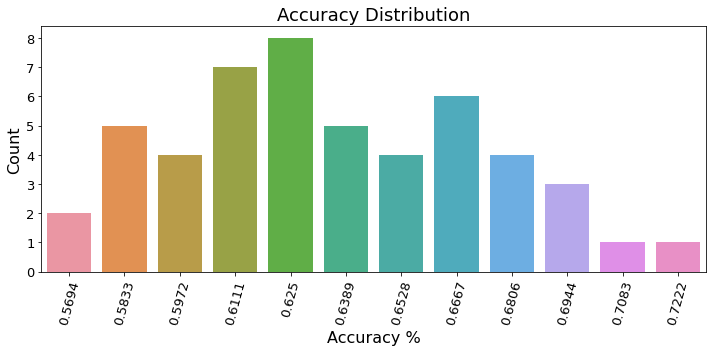

In [7]:
# now, let chart the accuracy distribution of the 100 runs
chart_results(accuracy_score_list)

#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [8]:
#curiam_new_df = pd.read_csv(curiam_engineered_data_csv)
#CX = vec.transform(curiam_new_df.text)
#predict = avg_model.predict(CX)
#predict
#CX

<35x1352359 sparse matrix of type '<class 'numpy.int64'>'
	with 61912 stored elements in Compressed Sparse Row format>

In [10]:
def predict_per_curiam_text(curiam_df, curiam_transformed_data, model, model_name, justice_names, justices_map):
    tmp_justice_dict = dict()
    value_list = [model_name]

    for justice_name in sorted(justice_names):
        tmp_justice_dict[justice_name] = 0

    classification_columns = ['Classifier']
    classification_columns.extend(sorted(justice_names))
    tmp_classification_df = pd.DataFrame(columns=classification_columns)

    predict = model.predict(curiam_transformed_data)
    model_predicted_df = pd.DataFrame()
    model_predicted_df['case'] = curiam_df['case']
    model_predicted_df['justice'] = [justices_map[x] for x in predict]

    pc_series = model_predicted_df.justice.value_counts()
    pc_names = pc_series.index.tolist()
    pc_values = pc_series.values.tolist()
    for j_name, j_count in list(zip(pc_names, pc_values)):
        tmp_justice_dict[j_name] = j_count

    for justice in sorted(tmp_justice_dict.keys()):
        value_list.append(tmp_justice_dict[justice])

    tmp_df = pd.DataFrame([value_list], columns=classification_columns)

    return tmp_df

In [ ]:
#curiam_avg_predicted_df = pd.DataFrame()
#curiam_avg_predicted_df['case'] = curiam_new_df['case']
#curiam_avg_predicted_df['justice'] = [justices_map[x] for x in predict]

In [11]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, avg_model, 'LinearSVC', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.6388888888888888
index of closest accuracy score: 3
closest accuracy score found 5 times
indexes: [ 3 13 17 33 34]
choosing model from index: 33


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,6,0,0,0,25,0,2,0,2


In [12]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, best_model, 'LinearSVC', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [19]
max accuracy: 19
choosing model from index: 0.7222222222222222


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,7,0,1,0,20,3,2,0,2


### Random Forest
Run Random Forest models on extracted tex:<br>
&nbsp; &nbsp; &nbsp; &nbsp; 1) setup <br>
&nbsp; &nbsp; &nbsp; &nbsp; 2) grid search<br>
&nbsp; &nbsp; &nbsp; &nbsp; 3) classify the curiam decisions<br>

#### 1) 50 runs

In [13]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_n_times(X=X, y=y, model='RandomForest', runs=50)

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['RandomForest', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)
accuracy_summary_df

AVERAGE ACCURACY: 0.6475
ACCURACY STD: 0.0483
HIGHEST ACCURACY: 0.7222


,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,63.53,72.22
0,RandomForest,64.75,72.22


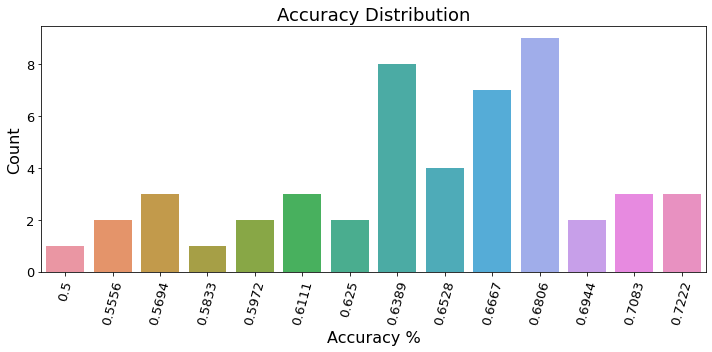

In [14]:
# now, let chart the accuracy distribution of the 100 runs
chart_results(accuracy_score_list)

#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [16]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, avg_model, 'RandomForest', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.6527777777777778
index of closest accuracy score: 9
closest accuracy score found 4 times
indexes: [ 9 19 24 27]
choosing model from index: 9


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,6,0,0,0,25,0,2,0,2
0,RandomForest,0,0,26,0,3,2,3,0,1


In [17]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, best_model, 'RandomForest', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [ 5 20 26]
max accuracy: 20
choosing model from index: 0.7222222222222222


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,7,0,1,0,20,3,2,0,2
0,RandomForest,0,0,15,0,1,16,1,0,2


### MultinomialNB

#### 1) 50 runs

In [18]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_n_times(X=X, y=y, model='MultinomialNB', runs=50)

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['MultinomialNB', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)
accuracy_summary_df

AVERAGE ACCURACY: 0.3117
ACCURACY STD: 0.0451
HIGHEST ACCURACY: 0.4028


,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,63.53,72.22
0,RandomForest,64.75,72.22
0,MultinomialNB,31.17,40.28


#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [19]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, avg_model, 'MultinomialNB', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.3055555555555556
index of closest accuracy score: 2
closest accuracy score found 10 times
indexes: [ 2 11 20 25 27 36 38 43 46 48]
choosing model from index: 48


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,6,0,0,0,25,0,2,0,2
0,RandomForest,0,0,26,0,3,2,3,0,1
0,MultinomialNB,24,0,0,1,7,0,0,3,0


In [20]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, best_model, 'MultinomialNB', justice_names,
                             justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [ 6 44]
max accuracy: 6
choosing model from index: 0.4027777777777778


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,7,0,1,0,20,3,2,0,2
0,RandomForest,0,0,15,0,1,16,1,0,2
0,MultinomialNB,14,0,0,3,15,0,0,3,0


### Cosine Similarity
Run cosine similarity on extracted text:<br>
&nbsp; &nbsp; &nbsp; &nbsp; 1) word frequenty <br>
&nbsp; &nbsp; &nbsp; &nbsp; 2) tf-df<br>
&nbsp; &nbsp; &nbsp; &nbsp; 3) word embedding<br>

In [21]:
# load data
all_decisions_df = pd.read_csv(similarity_csv)

#### By word frequency

In [22]:
identifiers = all_decisions_df.identifier.tolist()
decisions = all_decisions_df.text.tolist()

In [23]:
count_sim_array = calculate_similarities_count(data=decisions)
count_sim_df = most_similar(documents=identifiers, sim_array=count_sim_array)
count_sim_df.most_similar_justice = count_sim_df.most_similar_justice.apply(lambda x: x.split(':')[1])
count_sim_df.identifier = count_sim_df.identifier.apply(lambda x: x.split(':')[0])

In [30]:
# each document has high similarity with multiple documents. We'll get back to this
count_sim_df

,identifier,most_similar_justice,similarity_score
0,case-562-594,Thomas,0.685703
1,case-562-594,Ginsburg,0.680951
2,case-562-594,Alito,0.652795
3,case-568-17,Ginsburg,0.674142
4,case-568-17,Thomas,0.671948
...,...,...,...
100,case-577-14-10008,Thomas,0.430864
101,case-577-14-10008,Sotomayor,0.419109
102,case-577-14-1143,Alito,0.692457
103,case-577-14-1143,Alito,0.584555


#### By tf-idf

In [25]:
tfidf_sim_array = calculate_similarities_tfidf(data=decisions)
tfidf_sim_df = most_similar(documents=identifiers, sim_array=tfidf_sim_array)
tfidf_sim_df.most_similar_justice = tfidf_sim_df.most_similar_justice.apply(lambda x: x.split(':')[1])
tfidf_sim_df.identifier = tfidf_sim_df.identifier.apply(lambda x: x.split(':')[0])

In [29]:
# these results are REALLY bad; not work exploring any further
tfidf_sim_df

,identifier,most_similar_justice,similarity_score
0,case-562-594,Alito,0.127944
1,case-562-594,Roberts,0.126964
2,case-562-594,Thomas,0.126552
3,case-568-17,Ginsburg,0.094226
4,case-568-17,Scalia,0.089307
...,...,...,...
100,case-577-14-10008,Kennedy,0.057970
101,case-577-14-10008,Thomas,0.057734
102,case-577-14-1143,Alito,0.205443
103,case-577-14-1143,Alito,0.123560


#### By Word Embedding

In [27]:
# firest we need to add aunicode column for gensim to work properly
all_decisions_df['text_unicode'] = all_decisions_df.apply(lambda x: [token for token in simple_preprocess(x.text,
                                                                                                       min_len=0,
                                                                                                       max_len=float("inf"))], axis=1
                                                                                                      )

##### using Google generated word vectors

In [28]:
embed_sim_df = calculate_similarities_embed(gdf=all_decisions_df)
embed_sim_df

100%|██████████| 21953/21953 [01:36<00:00, 228.36it/s]


starting enumerate
working on number: 0
working on number: 25
working on number: 50
working on number: 75
working on number: 100
working on number: 125
working on number: 150
working on number: 175
working on number: 200
working on number: 225
working on number: 250
working on number: 275
working on number: 300
working on number: 325
working on number: 350
working on number: 375


,case,most_similar,similarity_score,avg_similarity,score_avg_difference
0,case-562-594:unknown,case-578-14-8349:Thomas,0.5557,0.2534,0.3023
1,case-568-17:unknown,case-577-15-648:unknown,0.3838,0.1943,0.1895
2,case-574-21:unknown,case-568-313:Sotomayor,0.4070,0.1964,0.2106
3,case-577-14-848:unknown,case-571-263:unknown,0.2742,0.1193,0.1549
4,case-575-14-939:unknown,case-563-493:Alito,0.3597,0.1797,0.1800
...,...,...,...,...,...
390,case-564-786:Scalia,case-564-786:Alito,0.7858,0.2379,0.5479
391,case-576-13-628:Scalia,case-566-189:Roberts,0.7033,0.2204,0.4829
392,case-572-489:Scalia,case-576-14-46:Kagan,0.7167,0.1840,0.5327
393,case-576-14-114:Scalia,case-576-14-114:Roberts,0.8614,0.2613,0.6001


In [31]:
embed_sim_df.head(35)

,case,most_similar,similarity_score,avg_similarity,score_avg_difference
0,case-562-594:unknown,case-578-14-8349:Thomas,0.5557,0.2534,0.3023
1,case-568-17:unknown,case-577-15-648:unknown,0.3838,0.1943,0.1895
2,case-574-21:unknown,case-568-313:Sotomayor,0.4070,0.1964,0.2106
3,case-577-14-848:unknown,case-571-263:unknown,0.2742,0.1193,0.1549
4,case-575-14-939:unknown,case-563-493:Alito,0.3597,0.1797,0.1800
5,case-562-1:unknown,case-577-14-449:Scalia,0.5576,0.2650,0.2926
6,case-575-14-593:unknown,case-565-400:Scalia,0.5690,0.2168,0.3522
7,case-577-15-648:unknown,case-578-14-8349:Thomas,0.5292,0.2140,0.3152
8,case-565-520:unknown,case-566-650:unknown,0.3050,0.1484,0.1566
9,case-578-15-723:unknown,case-566-156:Kennedy,0.2118,0.1027,0.1091


##### These are really bad as well. Let's use the custom generated word vectors

In [32]:
custom_embed_sim_df = calculate_similarities_embed(gdf=all_decisions_df, vectors=True)
print(f'similarity by word embedding')

100%|██████████| 21953/21953 [00:00<00:00, 24545.02it/s] 


starting enumerate
working on number: 0
working on number: 25
working on number: 50
working on number: 75
working on number: 100
working on number: 125
working on number: 150
working on number: 175
working on number: 200
working on number: 225
working on number: 250
working on number: 275
working on number: 300
working on number: 325
working on number: 350
working on number: 375
similarity by word embedding


In [33]:
# these are really bad as well; not worth exploring any further 
custom_embed_sim_df

,case,most_similar,similarity_score,avg_similarity,score_avg_difference
0,case-562-594:unknown,case-565-520:unknown,0.4686,0.0868,0.3818
1,case-568-17:unknown,case-563-333:Scalia,0.2240,0.0463,0.1777
2,case-574-21:unknown,case-569-597:Ginsburg,0.2063,0.0579,0.1484
3,case-577-14-848:unknown,case-571-263:unknown,0.1887,0.0280,0.1607
4,case-575-14-939:unknown,case-566-318:Kennedy,0.1815,0.0520,0.1295
...,...,...,...,...,...
390,case-564-786:Scalia,case-564-786:Alito,0.8379,0.0908,0.7471
391,case-576-13-628:Scalia,case-566-189:Roberts,0.6103,0.0830,0.5273
392,case-572-489:Scalia,case-576-14-46:Kagan,0.6378,0.0662,0.5716
393,case-576-14-114:Scalia,case-576-14-114:Roberts,0.8259,0.1000,0.7259


#### get most similar justice by simple word count

In [37]:
# the only one worth futher investigation is the frequency count
# let's get the top 20 documents for each and work with that
count20_sim_array = calculate_similarities_count(data=decisions)
top_20_count_by_case_df = most_similar(documents=identifiers, sim_array=count20_sim_array, num_highest=20)
top_20_count_by_case_df.most_similar_justice = top_20_count_by_case_df.most_similar_justice.apply(lambda x: x.split(':')[1])
top_20_count_by_case_df.identifier = top_20_count_by_case_df.identifier.apply(lambda x: x.split(':')[0])

In [38]:
### view the data by how many times a justice was matched
results_df = top_20_count_by_case_df.groupby('most_similar_justice').agg({'most_similar_justice': ['count']}).round(2)
results_df.columns = [col[1] for col in results_df.columns.values]
results_df.reset_index(level=0, inplace=True)
results_df.rename(columns={'most_similar_justice': 'justice'}, inplace=True)
results_df

,justice,count
0,Alito,77
1,Breyer,40
2,Ginsburg,89
3,Kagan,60
4,Kennedy,77
5,Roberts,61
6,Scalia,135
7,Sotomayor,98
8,Thomas,63


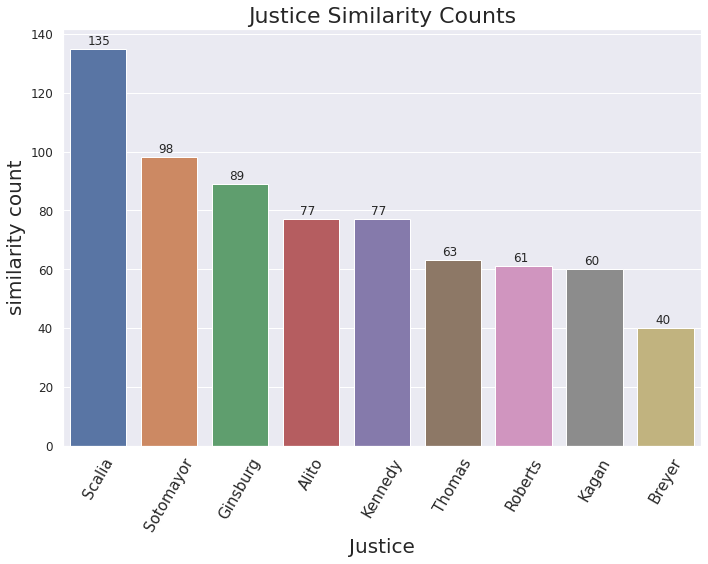

In [39]:
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x="most_similar_justice", data=top_20_count_by_case_df, 
                 order = top_20_count_by_case_df.most_similar_justice.value_counts().index)

for p in ax.patches:
   ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+1.5))

ax.set_xlabel('Justice',fontsize=20)
ax.set_ylabel('similarity count',fontsize=20)
ax.set_title('Justice Similarity Counts',fontsize=22)

plt.xticks(rotation=60, size=15)
plt.yticks(size=12)
plt.show()

In [40]:
most_similar_identifier_view_df = pd.crosstab(top_20_count_by_case_df.identifier,    
                 top_20_count_by_case_df.most_similar_justice)

In [41]:
most_similar_identifier_view_df

most_similar_justice,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
identifier,,,,,,,,,
case-562-1,1,0,3,3,2,2,5,2,2
case-562-216,2,0,4,2,2,3,4,1,2
case-562-594,1,1,5,1,1,3,3,4,1
case-565-1,2,1,2,2,3,1,4,4,1
case-565-23,4,0,1,1,1,1,5,6,1
case-565-388,1,2,3,2,4,1,3,1,3
case-565-469,7,4,0,0,0,2,4,3,0
case-565-520,3,2,3,1,0,2,4,4,1
case-565-65,0,1,4,2,2,3,4,3,1


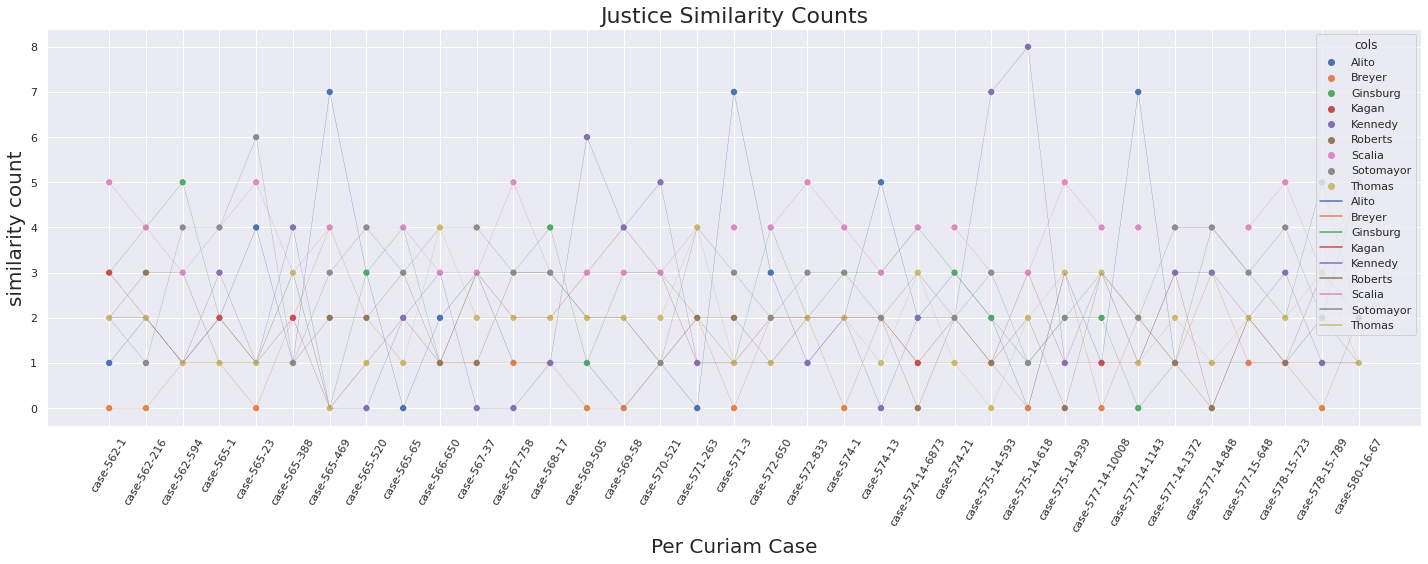

In [42]:
df = most_similar_identifier_view_df.copy()
df['index'] = df.index
df = df.melt('index', var_name='cols',  value_name='vals')
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [20,8]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x="index", y="vals", hue='cols', data=df, s=50)
sns.lineplot(x="index", y="vals", hue='cols', data=df, lw=.25).set(title='Cases Most Similar By Justice Counts')

plt.xlabel('Per Curiam Case',fontsize=20)
plt.ylabel('similarity count',fontsize=20)
plt.title('Justice Similarity Counts',fontsize=22)

plt.xticks(rotation=60)
plt.show()

In [43]:
# now let's see what happens if we join all the authored into single documents by author and run similariy against them
# since the combined texts will be signficantly larger than the individual decisison texts, the counts might have to be normalized
authored_decisions_df = pd.read_csv(authored_similarity_csv)

In [44]:
authored_decisions_df.head()

,case,justice,text,identifier
0,case-565-452,Kagan,federal meat inspection act fmia act usc et se...,case-565-452:Kagan
1,case-575-13-1019,Kagan,sue employer discrimination equal employment o...,case-575-13-1019:Kagan
2,case-578-15-339,Kagan,prison reform act plra inmate exhaust quoted_t...,case-578-15-339:Kagan
3,case-564-319,Kagan,consider sentencing reform act preclude federa...,case-564-319:Kagan
4,case-573-351,Kagan,provision federal bank usc make criminal know ...,case-573-351:Kagan


In [45]:
# first copy the identifer and text columns for all per curiam decisions
cur_df = all_decisions_df[all_decisions_df.identifier.str.contains('unknown')][['identifier','text']].copy()

# now combine all the texts for each justice and dump into new datafram
justices = authored_decisions_df.justice.unique()
new_texts = list()
author_combined_text_df = pd.DataFrame()
author_combined_text_df['identifier'] = justices
for justice in justices:
    texts = authored_decisions_df[authored_decisions_df.justice == justice]['text'].tolist()
    texts = [x.replace('quoted_text', '') for x in texts]
    new_texts.append(' '.join(texts))

author_combined_text_df['text'] = new_texts
author_combined_text_df.identifier = author_combined_text_df.identifier.apply(lambda x: f'{x}:{x}')

# finally, concat the dataframes
dataframes = [cur_df, author_combined_text_df]
combined_decisions = pd.concat(dataframes)
combined_decisions = combined_decisions.reset_index(drop=True)
combined_decisions.text = combined_decisions.text.str.replace('quoted_text', '')

identifiers = combined_decisions.identifier.tolist()
decisions = combined_decisions.text.tolist()

In [46]:
count_combined_sim_array = calculate_similarities_count(data=decisions)
count_combined_sim_df = most_similar(documents=identifiers, sim_array=count_combined_sim_array, num_highest=9)
count_combined_sim_df.most_similar_justice = count_combined_sim_df.most_similar_justice.apply(lambda x: x.split(':')[1])
count_combined_sim_df.identifier = count_combined_sim_df.identifier.apply(lambda x: x.split(':')[0])

In [47]:
count_combined_sim_df

,identifier,most_similar_justice,similarity_score
0,case-562-594,Ginsburg,0.577192
1,case-562-594,Kennedy,0.556237
2,case-562-594,Alito,0.526234
3,case-562-594,Scalia,0.510318
4,case-562-594,Thomas,0.501556
...,...,...,...
310,case-577-14-1143,Ginsburg,0.456546
311,case-577-14-1143,Scalia,0.455470
312,case-577-14-1143,Thomas,0.453698
313,case-577-14-1143,Kagan,0.433881


#### now let's look at the similarity scores by justice for a few of the curiam decisions

In [48]:
def display_case(df, case_name):
    sns.set(color_codes=True)
    plt.rcParams["figure.figsize"] = [7,5]
    plt.rcParams["figure.autolayout"] = True
    ax = sns.barplot(x="most_similar_justice", y="similarity_score", data=df)

    ax.set_xlabel('Justice',fontsize=16)
    ax.set_ylabel('Similarity',fontsize=16)
    ax.set_title(f'Similarty Scores for Case:  {case_name}',fontsize=18)

    plt.xticks(rotation=60, size=15)
    plt.yticks(size=12)
    plt.show()

In [80]:
# first let's get a random sample of the cases
case_list = curiam_engineered_df.case.tolist()
sample_cases = random.sample(case_list, 20)

# now let's group the data by case
grouped_by_identifier_df = count_combined_sim_df.groupby('identifier')

cases_df_dict = dict()
for case in sample_cases:
    cases_df_dict[case] = grouped_by_identifier_df.get_group(case)

In [70]:
#### now we can display the similarities for all three cases

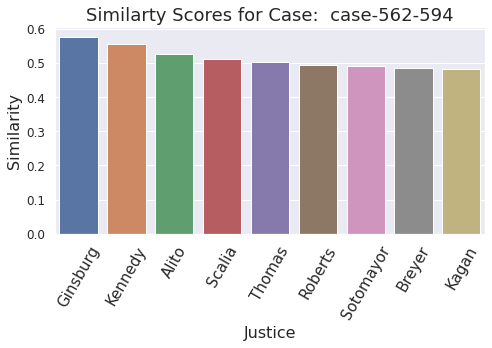

In [84]:
display_case(cases_df_dict[sample_cases[5]],sample_cases[5])

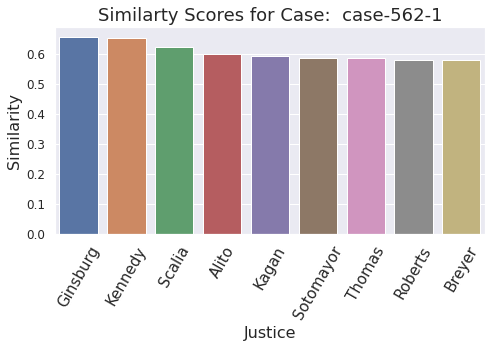

In [85]:
display_case(cases_df_dict[sample_cases[18]],sample_cases[18])

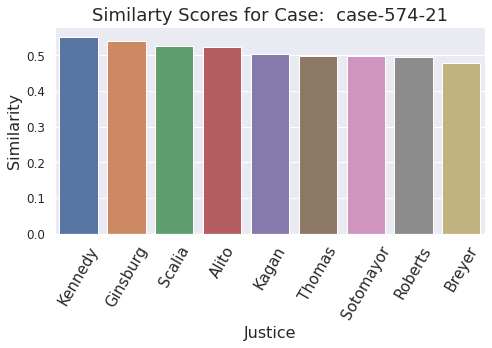

In [89]:
display_case(cases_df_dict[sample_cases[19]],sample_cases[19])

#### now let's look at the top 25 word counts for each justice

In [92]:
# similarities are extremely high; likely that even now a lot of the vocabulary between justices is the same
justice_dict = dict()
justice_list = list()
words_list = list()
counts_list = list()
position_list = list()
layout_dict = dict()
all_words = list()

wc_df = pd.DataFrame()
for j,t in zip(justices,new_texts):
    justice_dict[j] = t
    
for justice in justices:
    txt = justice_dict[justice]
    word_freq = Counter(txt.split())
    most_common = word_freq.most_common(25)
    layout_dict[justice] = [x[0] for x in most_common]
    all_words.extend([x[0] for x in most_common])
    
all_words_frequency = Counter(all_words)
awf_words =[x[0] for x in all_words_frequency.items()]
awf_count = [x[1] for x in all_words_frequency.items()]
wf_df = pd.DataFrame.from_dict({'word' : awf_words, 'frequency': awf_count})

for justice in justices:
    wc_df[justice] = layout_dict[justice]

In [93]:
wc_df = pd.DataFrame()
for justice in justices:
    wc_df[justice] = layout_dict[justice]
wc_df

,Kagan,Sotomayor,Alito,Thomas,Kennedy,Ginsburg,Roberts,Breyer,Scalia
0,court,court,court,court,court,court,court,court,court
1,u_s,u_s,u_s,u_s,u_s,u_s,u_s,u_s,u_s
2,federal,versus,versus,versus,versus,versus,versus,versus,versus
3,versus,state,case,federal,state,state,federal,federal,state
4,state,federal,state,law,case,federal,state,act,federal
5,case,case,federal,state,federal,case,law,law,law
6,government,law,law,case,law,law,case,state,case
7,law,congress,states,states,rule,states,government,case,act
8,congress,states,united,rule,states,act,act,district,states
9,states,majority,act,opinion,united,united,states,government,opinion


In [94]:
wf_df = pd.DataFrame.from_dict({'word' : awf_words, 'frequency': awf_count})
wf_df = wf_df.sort_values(by=['frequency'], ascending=False)
wf_df = wf_df.reset_index(drop=True)

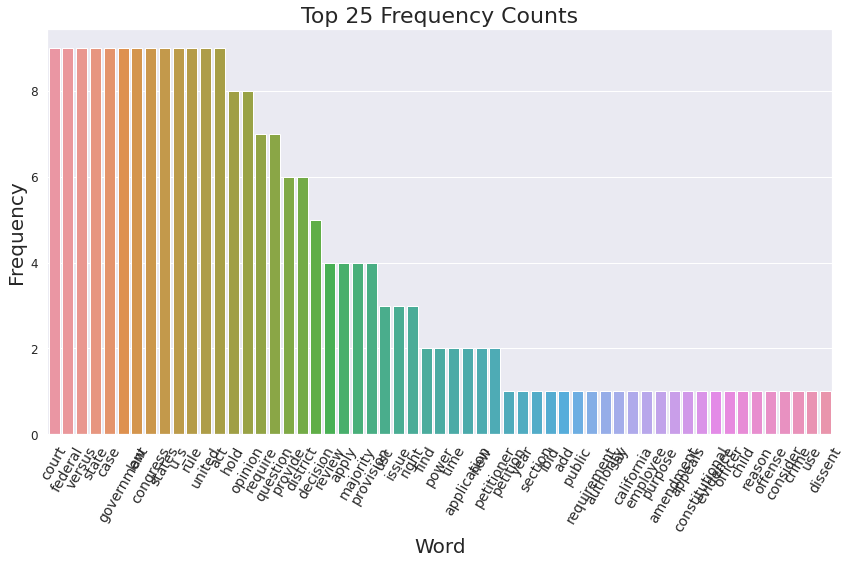

In [102]:
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(x="word", y="frequency", data=wf_df)

ax.set_xlabel('Word',fontsize=20)
ax.set_ylabel('Frequency',fontsize=20)
ax.set_title('Top 25 Frequency Counts',fontsize=22)

plt.xticks(rotation=60, size=14)
plt.yticks(size=12)
plt.show()

### Visualizations for classifications
At this point we have 3 dataframes with summary/aggregate information

In [106]:
accuracy_summary_df

,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,63.53,72.22
0,RandomForest,64.75,72.22
0,MultinomialNB,31.17,40.28


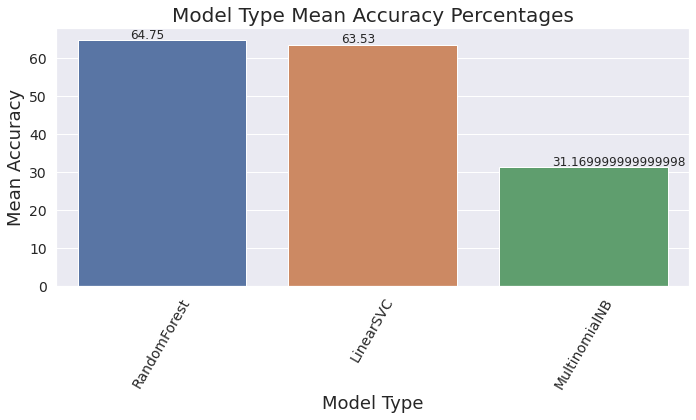

In [107]:
asd_by_mean_df = accuracy_summary_df.sort_values(by='Mean Accuracy', ascending = False)
plt.rcParams["figure.figsize"] = [10,6]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='Mean Accuracy', x="Classifier", data = asd_by_mean_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.5))

ax.set_xlabel('Model Type',fontsize=18)
ax.set_ylabel('Mean Accuracy',fontsize=18)
ax.set_title('Model Type Mean Accuracy Percentages',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

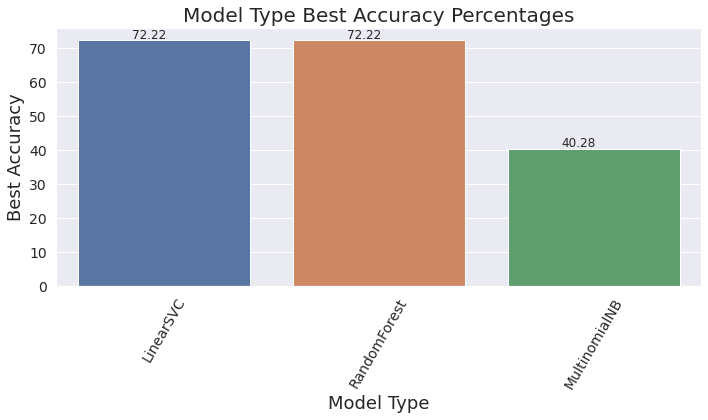

In [108]:
asd_by_best_df = accuracy_summary_df.sort_values(by='Best Accuracy', ascending = False)
plt.rcParams["figure.figsize"] = [10,6]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='Best Accuracy', x="Classifier", data = asd_by_best_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.5))

ax.set_xlabel('Model Type',fontsize=18)
ax.set_ylabel('Best Accuracy',fontsize=18)
ax.set_title('Model Type Best Accuracy Percentages',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

#### We can visualize the per curiam classifications by model type (avg, best) or classifier name
There are ten in total, so viewing all of them would be impracticaly. The dataframe view shows the large differences in how the per curiams were classified

In [109]:
mean_classification_df

,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,6,0,0,0,25,0,2,0,2
0,RandomForest,0,0,26,0,3,2,3,0,1
0,MultinomialNB,24,0,0,1,7,0,0,3,0


In [110]:
best_classification_df

,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,7,0,1,0,20,3,2,0,2
0,RandomForest,0,0,15,0,1,16,1,0,2
0,MultinomialNB,14,0,0,3,15,0,0,3,0


### Discussion
Classifying the per curiams by text only was no better than classifying them by features only. I was quite surprised by this as I expected the classifications to be somewhat better. The cosine similary results were equally surprising. As discussed in the presentation, the close similarity scores among the justices can indicate that the justices are, in fact, quite similar to each other, at least when it comes to writing Court decisions. This makes some sense as the documents have the following two features:<br>
1. highly stucture format<br>
2. high frequency of legal terms and entities<br><br>
